## <b>Uncertainty assessment</b>

This notebook is a demonstration on the uncertainty assessment for the tuned XGBoost model to remove uncertain points from the test set. The way this should be perceived is:
- This is a relatively small dataset (apart from FFV). This means that there are most likely going to be regions in which there is not enough data for the model to properly learn on - thus, uncertain regions. It would be unfair to say that the model is poor, because this is ultimately due to a bottleneck in the data, so an uncertainty assessment gives a more true assessment.
- Furthermore, this should be done on the two labels in which we are having some difficulties: Tg and Rg (elaboration done in EDA). The other properties are easily predicted, despite the small dataset sizes.
- The procedure is: (a) split dataset (D) into train/test and set test set aside, (b) bootstrap on train set --> construct training sets T_m where m is the mth bootstrapped set, (c) train XGB models on T_m to create an ensemble of models {f_1, ..., f_m}, (d) evaluate on test set with ensemble to get a set of predictions. Let's say N = number of test points, so your test prediction matrix will be (N, m), (e) get the mean and stdev of these predictions, (f) manually choose the stdev_threshold and remove points accordingly.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler

# models (linear regression, krr, xgb, tabPFN)
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge #krr
import xgboost as xgb #xgb

# feature selection + hyp opt
from sklearn.feature_selection import RFECV
from sklearn.metrics import get_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Integer
from skopt.space import Categorical
from sklearn.inspection import permutation_importance
from loguru import logger
import os
import json

import warnings
warnings.simplefilter('ignore')

In [ ]:
def bootstrapping(train_indices, df, label, descriptor_names, N_sets = 20):
    """
    df -> data_concat_prime?
    sampling with replacement on entire train_indices.. should get ~67% unique, 33% duplicates?

    inputs:
    - train_indices: array of indices that correspond to train set, after doing train/test split on pd.DataFrame
    - df: full pd.DataFrame
    - descriptor_names (list): selected features
    - N_sets: size of ensemble (int)
    """
    training_samples = [np.random.choice(train_indices, size = len(train_indices), replace = True) for _ in range(N_sets)]
    X_train_sets, y_train_sets = [], []

    for i in training_samples:
        X_train_sets.append(df.iloc[i][descriptor_names])
        y_train_sets.append(df.iloc[i][label])
    
    return X_train_sets, y_train_sets

#### <b>Impact of removing uncertain points</b>

<b>Label of interest: Tg (glass transition temperature)</b>

Cell below is just some data preprocessing:
- Merging DataFrames together
- Removing outliers on label via 1.5IQR rule
- Returns three variables: X (pd.DataFrame of features only), y (corresponding pd.Series of label), all_smiles (just to keep track - these are the corresponding SMILES strings for X and y).

In [ ]:
data_feat = pd.read_csv("data/RDKit_topological.csv")
data_feat = data_feat.dropna(axis = 1)
data_train = pd.read_csv("data/train.csv")

descriptor_names = data_feat.columns[2::].tolist()
labels = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
data_feat = data_feat[['SMILES'] + descriptor_names]
data_train = data_train[['SMILES'] + labels]

label = "Tg"
data_concat = data_feat.merge(data_train, on = 'SMILES', how = 'inner')
data_concat_prime = data_concat[['SMILES'] + descriptor_names + [label]]
data_concat_prime = data_concat_prime.dropna()
data_concat_prime = data_concat_prime.reset_index(drop = True)

Q1 = data_concat_prime[label].quantile(0.25)
Q3 = data_concat_prime[label].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
data_concat_prime = data_concat_prime[(data_concat_prime[label] >= lower) & (data_concat_prime[label] <= upper)]
data_concat_prime = data_concat_prime.reset_index(drop = True)

X, y, all_smiles = data_concat_prime[descriptor_names], data_concat_prime[label], data_concat_prime['SMILES']

Following block of code does the following:
- Does an 80/20 train/test split --> test set (i.e. test_indices) are set aside and not touched again
- The train set (train_indices) are bootstrapped to give X_train_sets (which is effectively a list of N_sets pd.DataFrames from X) and y_train_sets
- Load features from RFECV feature selection and best parameters from hyperparameter optimization for Tg
- Standardize by fitting StandardScaler TO TRAIN SET ONLY!

In [ ]:
split = 0.9
train_indices, test_indices = train_test_split(X.index, train_size = 0.8, random_state = 1)

N_sets = 20
X_train_sets, y_train_sets = bootstrapping(train_indices, data_concat_prime, label, descriptor_names = descriptor_names, N_sets = N_sets)

with open(f"saved_params/xgboost/{label}.json") as json_file:
    d = json.load(json_file)

features_used = d['features_used']
hp = d['bscv_result']['best_parameters']

scaler = StandardScaler()
scaler.fit(X[features_used].iloc[train_indices])

StandardScaler()

Following code block:
- Loops through each bootstrapped train set
- Scales using the standardizing object
- Fits XGB model and saves to folder for future use
- Evaluates ensemble on test set that was set aside

In [ ]:
# DON'T RUN THIS!!!! this is quite expensive :(

os.makedirs(f"uncertainty/{label}", exist_ok = True)

for i in range(N_sets):
    X_train, y_train = X_train_sets[i][features_used], y_train_sets[i]
    #scaler = StandardScaler()
    X_train_scaled = scaler.transform(X_train)

    model = xgb.XGBRegressor(**hp)
    model.fit(X_train_scaled, y_train)
    model.save_model(f"uncertainty/{label}/{i}.model")

# then, this part is going to do ensemble eval. on the test set that we set aside
X_test, y_test, smiles_test = data_concat_prime.iloc[test_indices][features_used], data_concat_prime.iloc[test_indices][label], data_concat_prime.iloc[test_indices]['SMILES']
X_test_scaled = scaler.transform(X_test)
ensemble_of_predictions = []

for i in range(N_sets):
    path_to_model = os.path.join(f"uncertainty/{label}", f"{i}.model")
    model = xgb.XGBRegressor(**hp)
    model.load_model(path_to_model)

    y_pred = model.predict(X_test_scaled)
    ensemble_of_predictions.append(y_pred)

ensemble_of_predictions = np.array(ensemble_of_predictions)
mean_preds = np.mean(ensemble_of_predictions, axis = 0)
std_preds = np.std(ensemble_of_predictions, axis = 0)

#### <b>Picking threshold manually</b>

This isn't.. really a scientific method of choosing a threshold. The way this was done was that I plotted a histogram of the standard deviations and eyeballed a reasonable threshold for a datapoint with too much uncertainty (i.e. the standard deviation was simply too high). In this case, you can see that a threshold of ~22 is pretty reasonable. Now, if you want a future step (or a more scientific method), maybe we can take 3 standard deviations from the mean of this distributions (since it is a left-skewed normal distribution to me...) and set that as a threshold :)

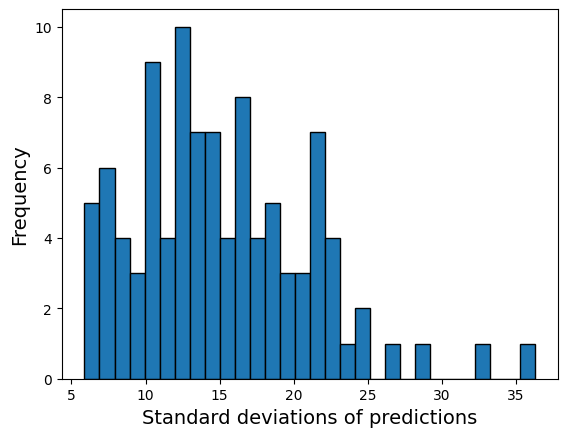

In [10]:
plt.hist(std_preds, bins = 30, edgecolor = 'black')
plt.xlabel("Standard deviations of predictions", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14)

plt.savefig(f"uncertainty/figures/{label}_stdev.pdf")

A fancy way is to make a widget, where you can run the code below and it should give you a widget (this ONLY works on VS Code though.. Not sure if it works on Jupyter Notebook), where you can slide the threshold value and based on reasonable thresholds, you can select it like this. It also saves a "snapshot" each time you slide the widget. The snapshot saves:
- test labels
- mean predictions
- standard deviation predictions
- the selected threshold (from widget)
- SRCC, MAE of what happens after you remove the uncertain points

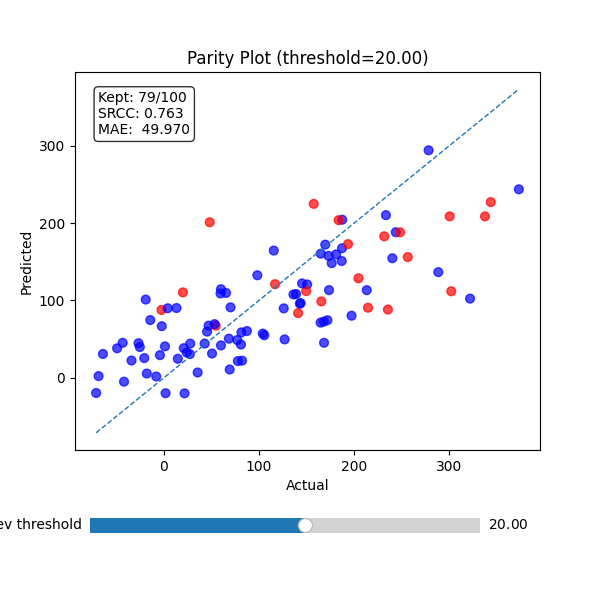

In [ ]:
%matplotlib widget

ensemble_of_predictions = np.array(ensemble_of_predictions)
mean_preds = np.mean(ensemble_of_predictions, axis=0)
std_preds = np.std(ensemble_of_predictions, axis=0)

init_threshold = 20

fig, ax = plt.subplots(figsize=(6, 6))
plt.subplots_adjust(bottom=0.25)

#red --> uncertain, blue --> certain... basically any points < threshold
colors = np.where(std_preds > init_threshold, "red", "blue")
sc = ax.scatter(y_test, mean_preds, c=colors, s=40, alpha=0.7)
xy_min = min(y_test.min(), mean_preds.min())
xy_max = max(y_test.max(), mean_preds.max())
ax.plot([xy_min, xy_max], [xy_min, xy_max], "--", linewidth=1)
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title(f"Parity Plot (threshold={init_threshold:.2f})")

mask_init = std_preds < init_threshold
y_keep_init = y_test[mask_init]
pred_keep_init = mean_preds[mask_init]
if np.sum(mask_init) > 1:
    srcc_init = spearmanr(y_keep_init, pred_keep_init).statistic
    mae_init = mean_absolute_error(y_keep_init, pred_keep_init)
else:
    srcc_init = np.nan
    mae_init = np.nan
metrics_str = (
    f"Kept: {mask_init.sum()}/{len(y_test)}\n"
    f"SRCC: {srcc_init:.3f}\n"
    f"MAE:  {mae_init:.3f}"
)
metrics_box = ax.text(
    0.05, 0.95, metrics_str,
    transform=ax.transAxes,
    va="top", ha="left",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

ax_thresh = plt.axes([0.15, 0.1, 0.65, 0.05])
thresh_slider = Slider(
    ax=ax_thresh,
    label="stdev threshold",
    valmin=0.0,
    valmax=float(std_preds.max()),
    valinit=init_threshold,
    valstep=0.01,
)
def save_snapshot(threshold, mask, srcc, mae, filename=f"uncertainty/parity_snapshot_{label}.npy"):
    """Save all relevant info to a single .npy file."""
    snapshot = {
        "y_test": y_test,
        "mean_preds": mean_preds,
        "std_preds": std_preds,
        "threshold": float(threshold),
        "mask_keep": mask,
        "srcc": float(srcc) if not np.isnan(srcc) else np.nan,
        "mae": float(mae) if not np.isnan(mae) else np.nan,
    }
    np.save(filename, snapshot, allow_pickle=True)

# save initial snapshot
save_snapshot(init_threshold, mask_init, srcc_init, mae_init)
def update(threshold):
    new_colors = np.where(std_preds > threshold, "red", "blue")
    sc.set_color(new_colors)

    mask = std_preds < threshold
    y_keep = y_test[mask]
    pred_keep = mean_preds[mask]
    if np.sum(mask) > 1:
        srcc = spearmanr(y_keep, pred_keep).statistic
        mae = mean_absolute_error(y_keep, pred_keep)
    else:
        srcc = np.nan
        mae = np.nan
    n_uncertain = (std_preds >= threshold).sum()
    ax.set_title(
        f"Parity Plot (threshold={threshold:.2f}, uncertain={n_uncertain})"
    )
    metrics_box.set_text(
        f"Kept: {mask.sum()}/{len(y_test)}\n"
        f"SRCC: {srcc:.3f}\n"
        f"MAE:  {mae:.3f}"
    )

    save_snapshot(threshold, mask, srcc, mae)
    fig.canvas.draw_idle()
thresh_slider.on_changed(update)
plt.show()

Ok, now we can repeat the exact same thing but for radius of gyration. This is the exact same code, but for Rg.

<b>Label of interest: Radius of gyration (Rg)</b>

In [ ]:
data_feat = pd.read_csv("data/RDKit_topological.csv")
data_feat = data_feat.dropna(axis = 1)
data_train = pd.read_csv("data/train.csv")

descriptor_names = data_feat.columns[2::].tolist()
labels = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
data_feat = data_feat[['SMILES'] + descriptor_names]
data_train = data_train[['SMILES'] + labels]

label = "Rg"
data_concat = data_feat.merge(data_train, on = 'SMILES', how = 'inner')
data_concat_prime = data_concat[['SMILES'] + descriptor_names + [label]]
data_concat_prime = data_concat_prime.dropna()
data_concat_prime = data_concat_prime.reset_index(drop = True)

Q1 = data_concat_prime[label].quantile(0.25)
Q3 = data_concat_prime[label].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
data_concat_prime = data_concat_prime[(data_concat_prime[label] >= lower) & (data_concat_prime[label] <= upper)]
data_concat_prime = data_concat_prime.reset_index(drop = True)

X, y, all_smiles = data_concat_prime[descriptor_names], data_concat_prime[label], data_concat_prime['SMILES']

In [ ]:
split = 0.9

train_indices, test_indices = train_test_split(X.index, train_size = 0.8, random_state = 1)

In [5]:
N_sets = 20
X_train_sets, y_train_sets = bootstrapping(train_indices, data_concat_prime, label, descriptor_names = descriptor_names, N_sets = N_sets)

with open(f"saved_params/xgboost/{label}.json") as json_file:
    d = json.load(json_file)

In [6]:
features_used = d['features_used']
hp = d['bscv_result']['best_parameters']

scaler = StandardScaler()
scaler.fit(X[features_used].iloc[train_indices])

StandardScaler()

In [7]:
# DON'T RUN THIS!!!!

os.makedirs(f"uncertainty/{label}", exist_ok = True)

for i in range(N_sets):
    X_train, y_train = X_train_sets[i][features_used], y_train_sets[i]
    #scaler = StandardScaler()
    X_train_scaled = scaler.transform(X_train)

    model = xgb.XGBRegressor(**hp)
    model.fit(X_train_scaled, y_train)
    model.save_model(f"uncertainty/{label}/{i}.model")

In [8]:
X_test, y_test, smiles_test = data_concat_prime.iloc[test_indices][features_used], data_concat_prime.iloc[test_indices][label], data_concat_prime.iloc[test_indices]['SMILES']
X_test_scaled = scaler.transform(X_test)
ensemble_of_predictions = []

for i in range(N_sets):
    path_to_model = os.path.join(f"uncertainty/{label}", f"{i}.model")
    model = xgb.XGBRegressor(**hp)
    model.load_model(path_to_model)

    y_pred = model.predict(X_test_scaled)
    ensemble_of_predictions.append(y_pred)

ensemble_of_predictions = np.array(ensemble_of_predictions)
mean_preds = np.mean(ensemble_of_predictions, axis = 0)
std_preds = np.std(ensemble_of_predictions, axis = 0)

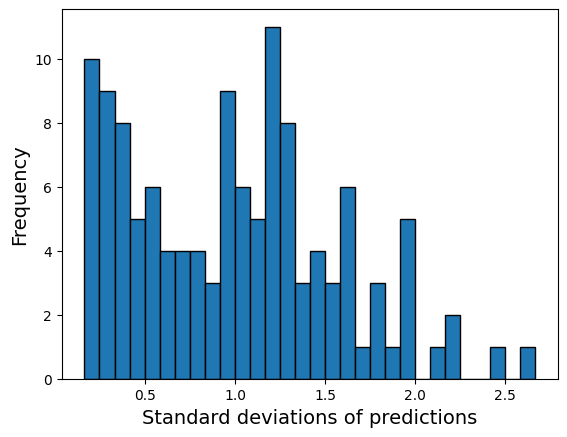

In [9]:
plt.hist(std_preds, bins = 30, edgecolor = 'black')
plt.xlabel("Standard deviations of predictions", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14)

plt.savefig(f"uncertainty/figures/{label}_stdev.pdf")

In [10]:
from matplotlib.widgets import Slider
%matplotlib widget

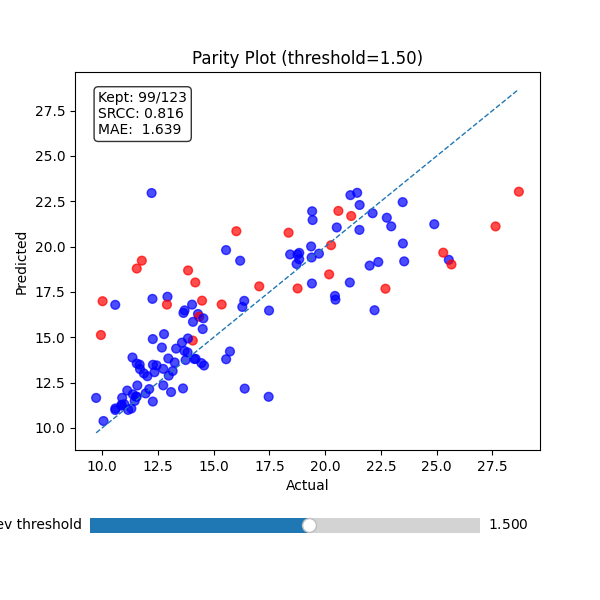

In [ ]:
ensemble_of_predictions = np.array(ensemble_of_predictions)
mean_preds = np.mean(ensemble_of_predictions, axis=0)
std_preds = np.std(ensemble_of_predictions, axis=0)

init_threshold = 1.5
fig, ax = plt.subplots(figsize=(6, 6))
plt.subplots_adjust(bottom=0.25)
colors = np.where(std_preds > init_threshold, "red", "blue")
sc = ax.scatter(y_test, mean_preds, c=colors, s=40, alpha=0.7)
xy_min = min(y_test.min(), mean_preds.min())
xy_max = max(y_test.max(), mean_preds.max())
ax.plot([xy_min, xy_max], [xy_min, xy_max], "--", linewidth=1)
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title(f"Parity Plot (threshold={init_threshold:.2f})")

mask_init = std_preds < init_threshold
y_keep_init = y_test[mask_init]
pred_keep_init = mean_preds[mask_init]
if np.sum(mask_init) > 1:
    srcc_init = spearmanr(y_keep_init, pred_keep_init).statistic
    mae_init = mean_absolute_error(y_keep_init, pred_keep_init)
else:
    srcc_init = np.nan
    mae_init = np.nan
metrics_str = (
    f"Kept: {mask_init.sum()}/{len(y_test)}\n"
    f"SRCC: {srcc_init:.3f}\n"
    f"MAE:  {mae_init:.3f}"
)
metrics_box = ax.text(
    0.05, 0.95, metrics_str,
    transform=ax.transAxes,
    va="top", ha="left",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

ax_thresh = plt.axes([0.15, 0.1, 0.65, 0.05])
thresh_slider = Slider(
    ax=ax_thresh,
    label="stdev threshold",
    valmin=0.0,
    valmax=float(std_preds.max()),
    valinit=init_threshold,
    valstep=0.01,
)
def save_snapshot(threshold, mask, srcc, mae, filename=f"uncertainty/parity_snapshot_{label}.npy"):
    """Save all relevant info to a single .npy file."""
    snapshot = {
        "y_test": y_test,
        "mean_preds": mean_preds,
        "std_preds": std_preds,
        "threshold": float(threshold),
        "mask_keep": mask,
        "srcc": float(srcc) if not np.isnan(srcc) else np.nan,
        "mae": float(mae) if not np.isnan(mae) else np.nan,
    }
    np.save(filename, snapshot, allow_pickle=True)

save_snapshot(init_threshold, mask_init, srcc_init, mae_init)
def update(threshold):
    # colors (red = uncertain, blue = kept)
    new_colors = np.where(std_preds > threshold, "red", "blue")
    sc.set_color(new_colors)
    # metrics for kept points
    mask = std_preds < threshold
    y_keep = y_test[mask]
    pred_keep = mean_preds[mask]
    if np.sum(mask) > 1:
        srcc = spearmanr(y_keep, pred_keep).statistic
        mae = mean_absolute_error(y_keep, pred_keep)
    else:
        srcc = np.nan
        mae = np.nan
    n_uncertain = (std_preds >= threshold).sum()
    ax.set_title(
        f"Parity Plot (threshold={threshold:.2f}, uncertain={n_uncertain})"
    )
    metrics_box.set_text(
        f"Kept: {mask.sum()}/{len(y_test)}\n"
        f"SRCC: {srcc:.3f}\n"
        f"MAE:  {mae:.3f}"
    )
    
    save_snapshot(threshold, mask, srcc, mae)
    fig.canvas.draw_idle()
thresh_slider.on_changed(update)
plt.show()